In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.readwrite import json_graph
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

## Create dataframe

In [38]:
from unicodedata import normalize

def remover_acentos(text, codif='utf-8'):
    return normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')

def get_response(data,codigo_orgao):
    pagina = 1
    response_df_total = []
    response_df = pd.DataFrame([1,2])
    
    while len(response_df) > 0:
        params = {"dataInicial": data, "dataFinal": data,"codigoOrgao": codigo_orgao, "pagina":pagina}

        response = requests.get(f"http://www.portaltransparencia.gov.br/api-de-dados/licitacoes",
                            params=params,
                            headers={
                                        "Accept": "*/*",
                                        "chave-api-dados": "88532616cca6060d6ced947c59523b37",
                            })
        response_df = pd.DataFrame(response.json())
        response_df_total.append(response_df)
        pagina += 1
        
    response_df = pd.concat(response_df_total,axis=0)
    return response_df

def get_siafe_orgao(orgao):
    try:
        return int(siafe_df[siafe_df["Órgão UGE Nome"]== orgao].iloc[-1,0])
    except:
        orgao = remover_acentos(orgao)
        return int(siafe_df[siafe_df["Órgão UGE Nome"]== orgao].iloc[-1,0])
    
    
def get_siafe_ug(data,codigo_orgao,numero,nome_ug):
    
    if data == "Sem informação":
        return None
    
    response_df = get_response(data,codigo_orgao)
    
    df_num = pd.DataFrame(list(response_df['licitacao']))        
    idx = df_num[df_num['numero']==numero].index[0]
    
    df_ug = pd.DataFrame(list(response_df['unidadeGestora']))
    
    return df_ug[df_ug['nome']==nome_ug]['codigo'].values[0]

def get_participantes(codigo_ug,numero):
    if codigo_ug ==  None:
        return None
    pagina = 1
    response_df_total = []
    params = {"codigoUG": codigo_ug, "numero":numero, "codigoModalidade":5}

    response = requests.get(f"http://www.portaltransparencia.gov.br/api-de-dados/licitacoes/participantes",
                        params=params,
                        headers={
                                    "Accept": "*/*",
                                    "chave-api-dados": "88532616cca6060d6ced947c59523b37",
                        })
    response_df = pd.DataFrame(response.json())
    if len(response_df) != 0:
        return ', '.join(list(response_df['nome']))
    else:
        return 'Não especificado'
    
    
portal_df = pd.read_csv('dados.csv',encoding='utf-8',sep=';')
import chardet
with open('SIAFE.csv', 'rb') as f:
    result = chardet.detect(f.readline())  # or readline if the file is large
  
    
siafe_df = pd.read_csv('SIAFE.csv',encoding=result['encoding'],sep=',')

portal_df['SIAFE ÓRGAO LICITANTE'] = portal_df['ÓRGÃO / ENTIDADE VINCULADA LICITANTE'].apply(lambda x: get_siafe_orgao(x))
portal_df['NÚMERO DA LICITAÇÃO'] = portal_df['NÚMERO DA LICITAÇÃO'].apply(lambda x: ''.join(x.split('/')))

codigo_ugs = []
parts_total = []

for i in range(len(portal_df)):
    data = portal_df.iloc[i,1]
    codigo_orgao = portal_df.iloc[i,-1]
    numero = portal_df.iloc[i,-4]
    nome_ug = portal_df.iloc[i,4]
    codigo_ug = get_siafe_ug(data,codigo_orgao,numero,nome_ug)
    codigo_ugs.append(codigo_ug)
    parts = get_participantes(codigo_ug, numero)
    parts_total.append(parts)
    
portal_df['CODIGO UG'] = codigo_ugs
portal_df['PARTICIPANTES'] = parts_total
portal_df.drop(['SITUAÇÃO','MODALIDADE DA LICITAÇÃO','INSTRUMENTO LEGAL DE CONTRATAÇÃO','OBJETO DA LICITAÇÃO'],inplace=True,axis=1)
portal_df.to_csv('opme.csv',index=False)
portal_df.head()

,DATA DE RESULTADO DA COMPRA,DATA DE ABERTURA,ORGÃO SUPERIOR LICITANTE,ÓRGÃO / ENTIDADE VINCULADA LICITANTE,UNIDADE GESTORA,NÚMERO DA LICITAÇÃO,Unnamed: 10,SIAFE ÓRGAO LICITANTE,CODIGO UG,PARTICIPANTES
0,Sem informação,19/09/2019,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DE SAO PAULO,PMSP-(HSPM)-HOSPITAL DO SERVIDOR PÚBLICO MUN,003242019,NaN,95420,925102,"BONE SURGICAL EQUIPAMENTOS MEDICOS EIRELI, OPM..."
1,30/01/2017,30/01/2017,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DO PARA,HOSPITAL OPHIR LOYOLA,000082017,NaN,93420,925450,Não especificado
2,16/08/2016,23/06/2016,MINISTERIO DA DEFESA,COMANDO DO EXERCITO,DEPARTAMENTO GERAL DE PESSOAL-MEX/DF,000022016,NaN,52121,160070,"PRIORI SERVICOS E SOLUCOES , CONTABILIDADE EIR..."
3,24/06/2016,27/04/2016,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DO PARA,HOSPITAL OPHIR LOYOLA,000442016,NaN,93420,925450,BIOMEDICAL PRODUTOS CIENTIFICOS MEDICOS E HOSP...
4,Sem informação,Sem informação,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DE SAO PAULO,PMSP-(HSPM)-HOSPITAL DO SERVIDOR PÚBLICO MUN,001452018,NaN,95420,None,None


## Extrair participantes

In [51]:
parts_total = portal_df[portal_df['PARTICIPANTES']!= "Não especificado"]['PARTICIPANTES'].dropna().apply(lambda x:  x.split(', '))
_parts = []
for parts in parts_total:
    for part in parts:
        if part != 'Não especificado':
            _parts.append(part)
            
dist_df = pd.DataFrame(_parts,columns=['Distribuidoras']).drop_duplicates()
dist_df.to_excel('distribuidores.xlsx',index=False)
dist_df

,Distribuidoras
0,BONE SURGICAL EQUIPAMENTOS MEDICOS EIRELI
1,OPME SOLUTION COMERCIO
2,IMPORTACAO E EXPORTACAO DE EQUIPAMENTOS MEDICO...
3,PRIORI SERVICOS E SOLUCOES
4,CONTABILIDADE EIRELI
...,...
207,LICITEC TECNOLOGIA EIRELI
208,TECNETWORKING SERVICOS E SOLUCOES EM TI LTDA
209,DAQSYS DADOS & CONTROLE LTDA
210,CISTEL COMERCIO DE ELETRO ELETRONICOS EIRELI


# Grafos

In [6]:
def get_nodes(portal_df,nomes):
    def get_node(portal_df,name,grupo):
        df = pd.DataFrame(dict(portal_df[name].value_counts()), index=['nodesize']).transpose()
        df['name'] = list(df.index)
        df['group'] = grupo
        df.set_index(np.arange(len(df)),inplace=True)
        return df
    nodes = []
    
    for nome in nomes:
        nodes.append(get_node(portal_df,nome,nomes.index(nome)+1))
    nodes_df = pd.concat(nodes)
    return nodes_df

nodes_df =  get_nodes(portal_df,['ORGÃO SUPERIOR LICITANTE','ÓRGÃO / ENTIDADE VINCULADA LICITANTE','UNIDADE GESTORA'])
nodes_df

,nodesize,name,group
0,8,REPUBLICA FEDERATIVA DO BRASIL,1
1,4,MINISTERIO DA DEFESA,1
2,1,MINISTERIO DO TURISMO,1
3,1,MINISTERIO DA EDUCACAO,1
4,1,MINIST. DA AGRICUL. PECUARIA E ABASTECIMENTO,1
0,5,ESTADO DAS ALAGOAS,2
1,3,COMANDO DO EXERCITO,2
2,2,ESTADO DE SAO PAULO,2
3,1,ESTADO DO PARA,2
4,1,MINISTERIO DA DEFESA,2


In [7]:
def get_edges(nodes_df,portal_df,nomes):
    edges=[]
    for grupo in range(1,3):
        nomes_grupo = list(nodes_df[nodes_df['group'] == grupo]['name'])
        for nome in nomes_grupo:
            destinos = list(portal_df[portal_df[nomes[grupo-1]]==nome][nomes[grupo]])
            for destino in destinos:
                edges.append([nome,destino, grupo])
    
    return pd.DataFrame(edges,columns='source target value'.split()).drop_duplicates()
    
            
edges_df = get_edges(nodes_df,portal_df,['ORGÃO SUPERIOR LICITANTE','ÓRGÃO / ENTIDADE VINCULADA LICITANTE','UNIDADE GESTORA'])
edges_df

,source,target,value
0,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DAS ALAGOAS,1
1,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DE SAO PAULO,1
4,REPUBLICA FEDERATIVA DO BRASIL,ESTADO DO PARA,1
8,MINISTERIO DA DEFESA,MINISTERIO DA DEFESA,1
9,MINISTERIO DA DEFESA,COMANDO DO EXERCITO,1
12,MINISTERIO DO TURISMO,MINISTERIO DO TURISMO,1
13,MINISTERIO DA EDUCACAO,EMPRESA BRASILEIRA DE SERVIÇOS HOSPITALARES,1
14,MINIST. DA AGRICUL. PECUARIA E ABASTECIMENTO,COMPANHIA NACIONAL DE ABASTECIMENTO,1
15,ESTADO DAS ALAGOAS,AGENCIA DE MODERNIZACAO DA GEST. DE PROCESSOS,2
20,COMANDO DO EXERCITO,HOSPITAL MILITAR DE ÁREA DE CAMPO GRANDE,2


## Render graph

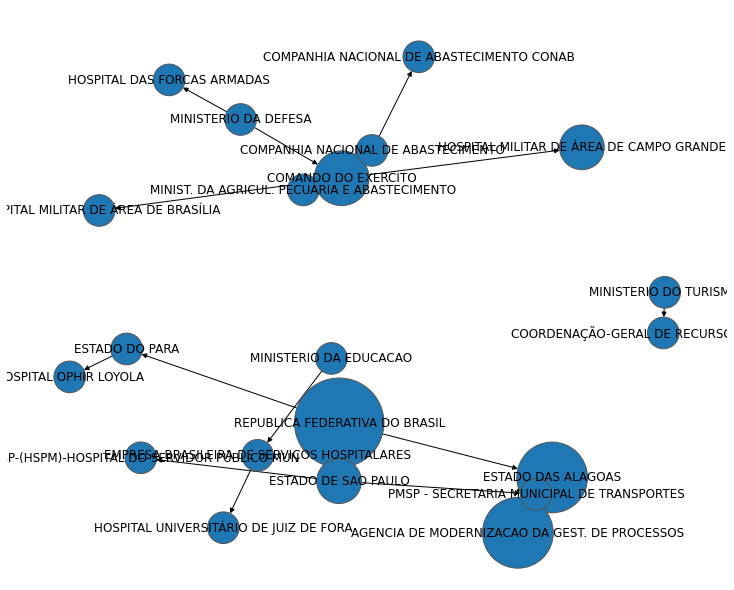

In [29]:
G = nx.DiGraph()
edges_grafo = edges_df
nodes_grafo = nodes_df
color_map = {1:'f09494', 2:'eebcbc', 3:'72bbd0'} 


for index, row in nodes_grafo.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=5*row['nodesize'],color=color_map[row['group']])
    
for index, row in edges_grafo.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], 10*row['value'])])
    

plt.figure(figsize=(10,8))
sizes = []

for node in G:
    try: 
        if G.nodes[node]!={}:
            sizes.append(G.nodes[node]['nodesize']*200)
    except: 
        pass

nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=1), with_labels= True, color=color_map)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.savefig('grafo.png')
plt.show()